In [ ]:
using QuantumAnnealingTools
using OrdinaryDiffEq
using Plots
using StatsBase

# Spin-fluctuator model (Classical 1/f noise) example
The total Hamiltonian in the first example is
\begin{equation}
 H(s) = -Z+ \frac{1}{2}\sum_i n_i(s) Z
\end{equation}
where $n_i(s)$ is the telegraph process with amplitude $b_i$ and fliping frequency $\gamma_i$. The summation $\sum_i n_i(s)$ generate "1/f" noise approximately.

The initial state is chosen to be
\begin{equation}
 \lvert \phi(0) \rangle = \lvert + \rangle \ .
\end{equation}

In [7]:
# generate the fliping rate of each telegraph noise in a log-uniformed fashion
function build_γ(start, stop, length)
    log_start = log10(start)
    log_stop = log10(stop)
    10 .^ (range(log_start, log_stop, length=length))
end

# calculate the mean and standard deviation of mean estimator from a sample
function mean_std(sample)
    m, v = mean_and_std(sample, corrected=true)
    m, v/sqrt(length(sample))
end;

In [8]:
# All the value created in the following codes is in angular frquencies unit
num = 10
bvec = 0.2 * ones(num)
γvec = build_γ(0.01, 1, num)
fluctuator_ensemble = EnsembleFluctuator(bvec, γvec);

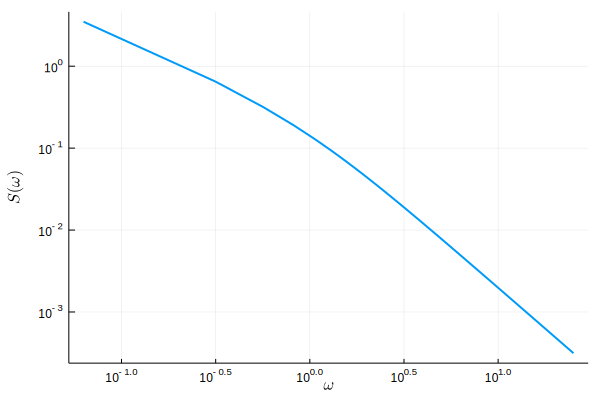

In [9]:
plot(fluctuator_ensemble, :spectrum, 2*π*range(0.01, 4, length=100), xscale=:log10, yscale=:log10, linewidth=2, label="")
xlabel!(L"\omega")
ylabel!(L"S(\omega)")

# Free Evolution
First we calculate the dynamics of the free evolution.

In [65]:
H = DenseHamiltonian([(s)->1], [σz], unit=:ħ)
coupling = ConstantCouplings([0.5*σz], unit=:ħ)
u0 = PauliVec[1][1]
annealing = Annealing(H, u0, coupling = coupling, bath=fluctuator_ensemble)

tf = 10
# create object for parallel simulation
prob, callback = build_ensemble_problem(annealing, tf, :stochastic_schrodinger);

In [66]:
sol = solve(prob, Tsit5(), EnsembleSerial(); trajectories=1000, callback=callback, abstol=1e-6, reltol=1e-6, saveat=range(0,1,length=100));

After the solution is obtained, we plot $\langle + \rangle$ against evolution time.

In [67]:
s_axis = range(0,1,length=100)
es = []
err = []
for (i, s) in enumerate(s_axis)
    sample = [abs2(u0'*so[i]) for so in sol]
    pop, pop_std = mean_std(sample)
    push!(es, pop)
    push!(err, 2*pop_std)
end

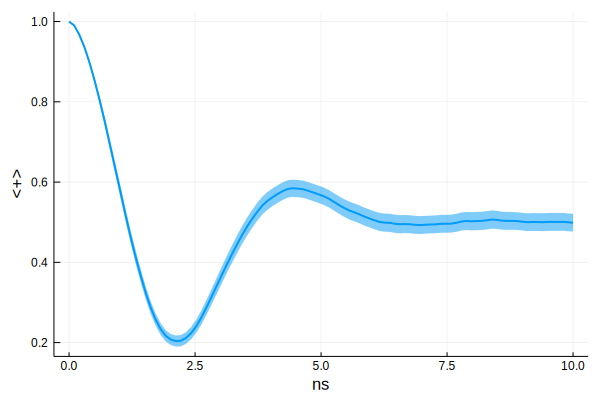

In [68]:
plot(tf*s_axis, es, ribbon=err, linewidth=2, label="")
xlabel!("ns")
ylabel!("<+>")

## Pulses in the middle
We can also apply instantaneous pulses during the middle of evolution using `InstPulseControl`. In the following example, we apply $X$ pulses at $s = 0.25, 0.5$ and $0.75$.

In [77]:
control = InstPulseControl([0.25, 0.5, 0.75], (x)->σx)
annealing = Annealing(H, u0, coupling = coupling, bath=fluctuator_ensemble, control=control)

Annealing with hType DenseHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
s parameter span: (0.0, 1.0)
u0 with size: (2,)
bath: Fluctuator ensemble with 10 fluctuators

In [78]:
tf = 10
prob, callback = build_ensemble_problem(annealing, tf, :stochastic_schrodinger)
sol = solve(prob, Tsit5(), EnsembleSerial(); trajectories=1000, callback=callback, abstol=1e-6, reltol=1e-6, saveat=range(0,1,length=100));

Again, we plot the $\langle + \rangle$ w.r.t the evolution time.

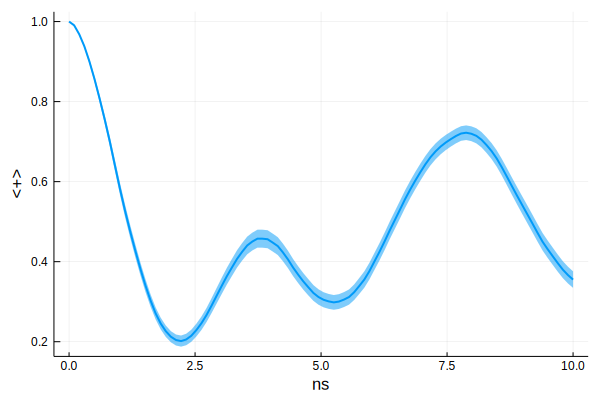

In [79]:
s_axis = range(0,1,length=100)
es = []
err = []
for (i, s) in enumerate(s_axis)
    sample = [abs2(u0'*so[i]) for so in sol]
    pop, pop_std = mean_std(sample)
    push!(es, pop)
    push!(err, 2*pop_std)
end

plot(tf*s_axis, es, ribbon=err, linewidth=2, label="")
xlabel!("ns")
ylabel!("<+>")

## Record the stochasic noise
We can also use [DEDataArray](https://docs.sciml.ai/latest/features/diffeq_arrays/#Data-Arrays-vs-ParameterizedFunctions-1) to record the noise value. For example, in the following example, we define a subtype of `DEDataArray` and record the noise value of each trajectory in the field `n`.

In [80]:
mutable struct DENoiseArray{T,N} <: DEDataArray{T,N}
    x::Array{T,N}
    n::Vector{Float64}
end
de_wrapper(x) = DENoiseArray(x, [1.0])

prob, callback = build_ensemble_problem(annealing, tf, :stochastic_schrodinger, de_array_constructor=de_wrapper, additional_field=:n)
sol = solve(prob, Tsit5(), EnsembleSerial(); trajectories=11, callback=callback, abstol=1e-6, reltol=1e-6);

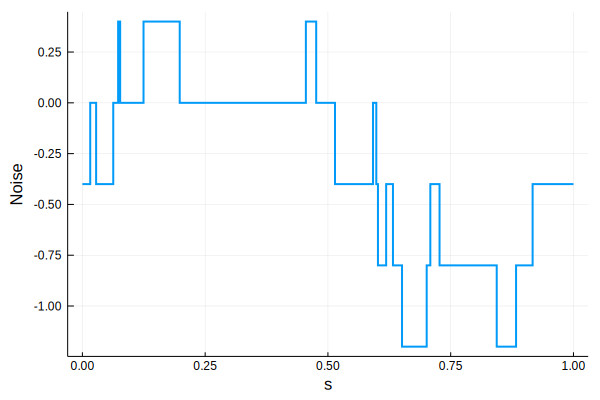

In [85]:
noise = [u.n[1] for u in sol[1].u]
plot(sol[1].t, noise, label="", linewidth=2)
xlabel!("s")
ylabel!("Noise")